In [1]:
import os
import sys
import json
import jsonschema
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [2]:
def read_json():
    with open('data/details_HU.json', 'r') as myfile:
        data_json = json.load(myfile)
    with open('data/schema.json', 'r') as myfile:
        schema_json = json.load(myfile)
    jsonschema.validate(data_json, schema_json)

    df = pd.json_normalize(data_json)
    # Remove template (source='')
    df = df[df["source"]!=""]
    # Convert date column and add week/dayofweek
    df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
    return df

In [3]:
myProcessing = md.DataProcessing.Preprocessing()
myProcessing.load_existing_data(data_dir="data")
myProcessing.add_aggregation()

In [4]:
df_additional = read_json()[["date","additional.infected"]].set_index("date")

In [5]:
df_tests = myProcessing.df["kpi_hu"][["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

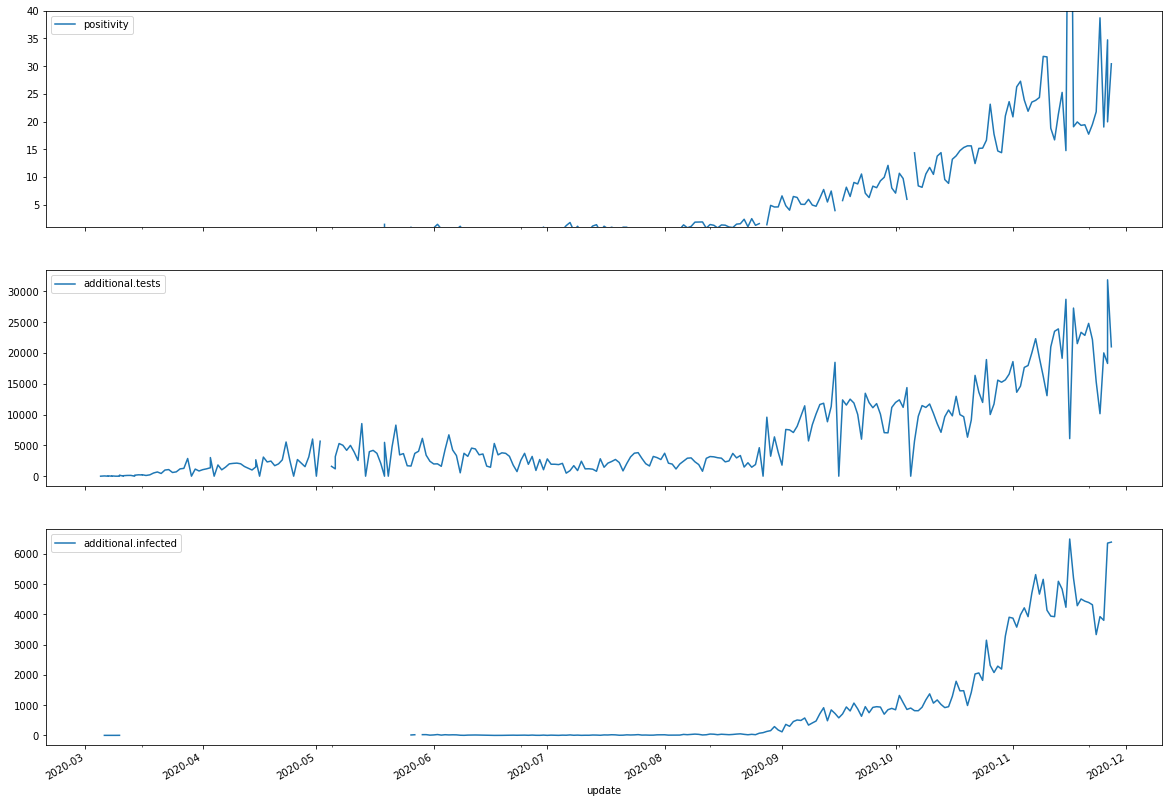

In [6]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,40)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

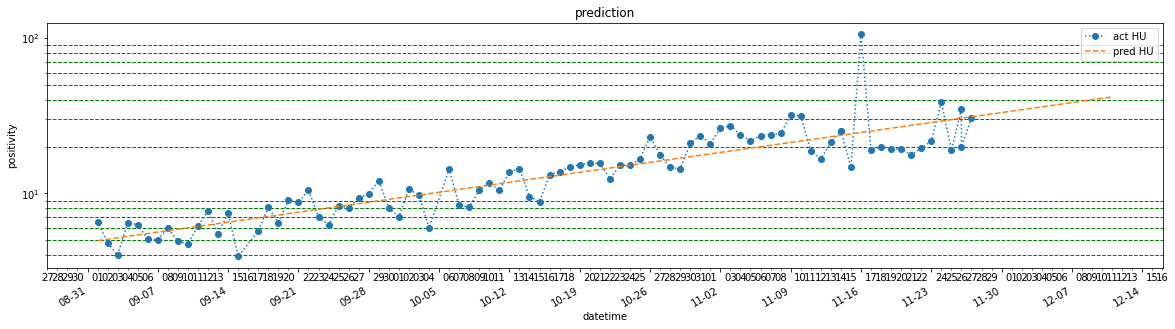

Coefficient of determination: {'HU': 0.7921427309273561}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
302,2020-11-24,1528302.0,10144.0,3929.0,38.732256,HU,2020-11-24
303,2020-11-25,1548318.0,20016.0,3806.0,19.014788,HU,2020-11-25
304,2020-11-26,1566619.0,18301.0,6360.0,34.752199,HU,2020-11-26
305,2020-11-26,1580197.0,31879.0,6360.0,19.950438,HU,2020-11-26
306,2020-11-27,1601203.0,21006.0,6393.0,30.434162,HU,2020-11-27


In [7]:
tmpDf = md.DataProcessing.Analyse.startAnalyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()